In [1]:
from data.byol_transform import *
import numpy as np
from model import BYOLModel
import yaml
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torch import nn
from skimage.segmentation import slic
from torchvision import transforms as TF
from utils.mask_utils import to_binary_mask,maskpool
from torchvision.models import resnet50
from torch import nn

In [2]:
model = resnet50(pretrained=True)
model = nn.Sequential(*list(model.children())[:-2])

/home/jacklishufan/miniconda3/envs/detcon/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/jacklishufan/miniconda3/envs/detcon/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
import kornia

In [4]:
stage = 'train'
mask_type = 'coco'
ROOT = '/shared/group/coco/'
image_dir = os.path.join(ROOT, f"{'train2017' if stage in ('train', 'ft') else 'val2017'}")
annoFile = os.path.join(ROOT,'annotations', f"{'instances_train2017.json' if stage in ('train', 'ft') else 'instances_val2017.json'}")
#mask_file = os.path.join(self.image_dir,'masks',stage+'_tf_img_to_'+self.mask_type+'.pkl')
transform1 = get_transform(stage)
transform2 = get_transform(stage, gb_prob=0.1, solarize_prob=0.2)
transform3 = get_transform('raw')
transform = MultiViewDataInjector([transform1, transform2,transform3],False,slic_segments=100)
dataset = COCOMaskDataset(image_dir,annoFile,transform)

loading annotations into memory...
Done (t=12.28s)
creating index...
index created!


In [5]:
data_loader = torch.utils.data.DataLoader(dataset,batch_size=4)

In [6]:
images,labels,roi_t = next(iter(data_loader))

In [7]:
labels.shape

torch.Size([4, 3, 2, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


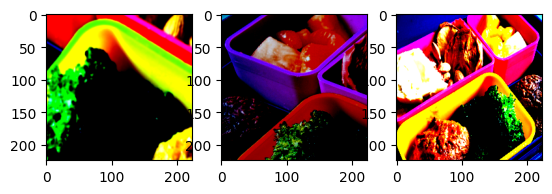

In [8]:
fig,ax = plt.subplots(1,3)
ax[0].imshow(images[0][0].permute(1,2,0))
ax[1].imshow(images[0][1].permute(1,2,0))
ax[2].imshow(images[0][2].permute(1,2,0))

In [9]:
labels[:,2,0].shape

torch.Size([4, 224, 224])

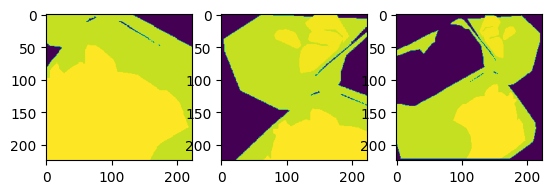

In [10]:
fig,ax = plt.subplots(1,3)
ax[0].imshow(labels[0][0][0])
ax[1].imshow(labels[0][1][0])
ax[2].imshow(labels[0][2][0])

In [11]:
def handle_flip(aligned_mask,flip):
        '''
        aligned_mask: B X C X 7 X 7
        flip: B 
        '''
        _,c,h,w = aligned_mask.shape
        b = len(flip)
        flip = flip.repeat(c*h*w).reshape(c,h,w,b) # C X H X W X B
        flip = flip.permute(3,0,1,2)
        flipped = aligned_mask.flip(-1)
        out = torch.where(flip==1,flipped,aligned_mask)
        return out
def inverse_align(features_1,features_2,roi_t,out_dim=56):
    '''
    features: N X C X H X W, view 1 & view 2
    '''
    n,c,h,w = features_1.shape
    roi_t_2 = roi_t.clone()
    dh =  (roi_t[...,2]-roi_t[...,0])
    dw =  (roi_t[...,3]-roi_t[...,1])
    roi_t_2[...,0] = (0.0 - roi_t[...,0]) / dh
    roi_t_2[...,1] = (0.0 - roi_t[...,1]) / dw
    roi_t_2[...,2] = (1.0 - roi_t[...,0]) / dh
    roi_t_2[...,3] = (1.0 - roi_t[...,1]) / dw
    idx = torch.LongTensor([1,0,3,2]).to(roi_t.device)
    mask_dim = features_1.shape[-1]
    rois_1 = [roi_t_2[j,:1,:4].index_select(-1, idx)*mask_dim for j in range(roi_t.shape[0])]
    rois_2 = [roi_t_2[j,1:2,:4].index_select(-1, idx)*mask_dim for j in range(roi_t.shape[0])]
    flip_1 = roi_t[:,0,4]
    flip_2 = roi_t[:,1,4]
    assert features_1.shape == features_2.shape
    aligned_1 = ops.roi_align(handle_flip(features_1,flip_1),rois_1,out_dim)
    aligned_2 = ops.roi_align(handle_flip(features_2,flip_2),rois_2,out_dim)
    mask = torch.ones(n,1,h,w).to(features_1.device).float()
    mask_aligned1 = ops.roi_align(handle_flip(mask,flip_1),rois_1,out_dim)
    mask_aligned2 = ops.roi_align(handle_flip(mask,flip_2),rois_2,out_dim)
    return aligned_1,aligned_2,(mask_aligned1*mask_aligned2 > 0).float()

In [126]:
roi_t_2 = roi_t.clone()

In [74]:
torch.cat([roi_t[:,[0,1,2]],roi_t[:,[1,0,2]]]).shape

torch.Size([64, 3, 5])

In [127]:
dh =  (roi_t[...,2]-roi_t[...,0])
dw =  (roi_t[...,3]-roi_t[...,1])
roi_t_2[...,0] = (0.0 - roi_t[...,0]) / dh
roi_t_2[...,1] = (0.0 - roi_t[...,1]) / dw
roi_t_2[...,2] = (1.0 - roi_t[...,0]) / dh
roi_t_2[...,3] = (1.0 - roi_t[...,1]) / dw

In [128]:
#roi_t = transforms
idx = torch.LongTensor([1,0,3,2]).to(roi_t.device)
mask_dim = labels[0][0][0].shape[0]
rois_1 = [roi_t_2[j,:1,:4].index_select(-1, idx)*mask_dim for j in range(roi_t.shape[0])]
rois_2 = [roi_t_2[j,1:2,:4].index_select(-1, idx)*mask_dim for j in range(roi_t.shape[0])]
flip_1 = roi_t[:,0,4]
flip_2 = roi_t[:,1,4]

In [129]:
roi_t[0][1]

tensor([0.2729, 0.1953, 0.9479, 0.8453, 1.0000])

In [130]:
roi_t_2[0][1]

tensor([-0.4043, -0.3005,  1.0772,  1.2380,  1.0000])

In [131]:
rois_2

[tensor([[-67.3077, -90.5679, 277.3077, 241.2840]]),
 tensor([[ -1.8398, -29.8667, 292.5339, 224.5974]]),
 tensor([[-150.2439,  -14.8344,  286.8293,  302.6225]]),
 tensor([[-58.8966,  -9.4068, 250.0690, 240.4619]])]

In [136]:
flip_1

tensor([0., 1., 1., 0.])

In [140]:
aligned_1 = ops.roi_align(handle_flip(labels[:,0,0:1].float(),flip_1),rois_1,56)
aligned_2 = ops.roi_align(handle_flip(labels[:,1,0:1].float(),flip_2),rois_2,56)

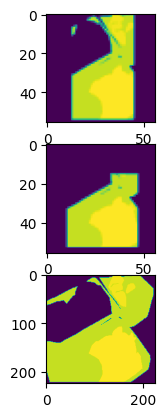

In [143]:
fig,ax = plt.subplots(3,1)
ax[0].imshow(aligned_1[0,0].long())
ax[1].imshow(aligned_2[0,0].long())
ax[2].imshow(labels[0][2][0])
# ax[1].imshow(labels[0][1][0])
# ax[2].imshow(labels[0][2][0])

In [164]:
rec0,rec1,msk = inverse_align(images[:,0],images[:,1],roi_t,500)

In [165]:
msk.shape

torch.Size([4, 1, 500, 500])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


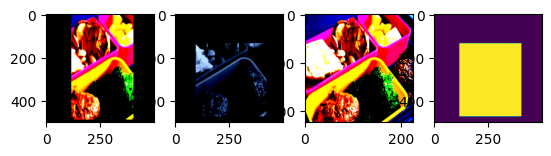

In [166]:
fig,ax = plt.subplots(1,4)
ax[0].imshow(rec0[0].permute(1,2,0))
ax[1].imshow(rec1[0].permute(1,2,0))
ax[3].imshow(msk[0].permute(1,2,0))
ax[2].imshow(images[0][2].permute(1,2,0))

In [ ]:
#path = '/shared/jacklishufan/05-18-01-49-300.pth'
#path = '/shared/jacklishufan/pixpro-400.pth'
#path = '/shared/jacklishufan/07-18-16-25.pth'
#path = '/shared/jacklishufan/ablation2/11-05-03-13.pth'
path = '/shared/jacklishufan/mmcls/region-cl-200.pth'
#path = '/shared/jacklishufan/detcoon-fullscale-bn-300.pth'
'/shared/jacklishufan/densecl-200-res50.pth'

In [62]:
model = resnet50(pretrained=True)
model.load_state_dict(torch.load('/shared/jacklishufan/pixpro-400.pth'))

<All keys matched successfully>

In [63]:
model = nn.Sequential(*list(model.children())[:-2])
model.eval()
device = 'cuda'
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [64]:
from tqdm.cli import tqdm

In [65]:
data_loader = torch.utils.data.DataLoader(dataset,batch_size=32,shuffle=True)

In [68]:

pixels = []
objects = []
c = 0
N = 100
bn_layer = nn.Identity()
bn_layer = nn.BatchNorm2d(2048)
bn_layer.cuda()
bn_layer.train()
for images,labels,roi_t in tqdm(data_loader):
    with torch.no_grad():
        images = images.to(device)
        labels = labels.to(device)
        roi_t = roi_t.to(device)
        view1 = images[:,0]
        view2 = images[:,1]
        hl = view1.shape[0]
        feature_all = model(torch.cat([view1,view2]))
        #feature_1 = F.normalize(feature_1,dim=-1)
        feature_all = bn_layer(feature_all)
        feature_1,feature_2 = feature_all[:hl],feature_all[hl:]
        #feature_2 = F.normalize(feature_2,dim=-1)
        PIXEL_DIM = 28
        feature_1,feature_2,msk_overlap = inverse_align(feature_1,feature_2,roi_t,PIXEL_DIM)
        mask_raw = F.interpolate(labels[:,2:3,0].float(),(PIXEL_DIM,PIXEL_DIM))[:,0]
        mask_intersect_object = mask_raw  * msk_overlap[:,0].long()
        gt_mask = to_binary_mask(mask_intersect_object.long()).cuda()
        feature_1_pooled,_ = maskpool(gt_mask,feature_1.cuda())
        feature_2_pooled,_ = maskpool(gt_mask,feature_2.cuda())
        feature_1 =  F.normalize(feature_1,dim=1)
        feature_2 =  F.normalize(feature_2,dim=1)
        feature_1_pooled = F.normalize(feature_1_pooled,dim=-1)
        feature_2_pooled = F.normalize(feature_2_pooled,dim=-1)
        mask_exist = (gt_mask.sum(dim=(-1,-2)) > 0).long()
        mask_exist[:,0] = 0.0
        alignment_pixel = (((feature_1 * feature_2)).sum(1,keepdims=True) * msk_overlap).sum((-1,-2)) /(1e-9+ msk_overlap.sum((-1,-2)))
        pixels.append(alignment_pixel.mean().item())
        alignment_object = ((feature_1_pooled * feature_2_pooled).sum(-1) * mask_exist).sum() / mask_exist.sum()
        objects.append(alignment_object.mean().item())
        print(np.mean(pixels),np.mean(objects))
    c += 1
    if c >= N:
        break

  0%|                                                     | 1/3665 [00:07<7:50:26,  7.70s/it]

0.6473744511604309 0.7266117334365845


  0%|                                                     | 2/3665 [00:13<6:32:18,  6.43s/it]

0.6358973681926727 0.7427112758159637


  0%|                                                     | 3/3665 [00:21<7:15:00,  7.13s/it]

0.6468435724576315 0.7364342212677002


  0%|                                                     | 3/3665 [00:25<8:36:42,  8.47s/it]


KeyboardInterrupt: 

In [109]:
np.mean(pixels),np.mean(objects)

0.845014750957489

In [103]:
pixel_attention = torch.einsum('nda,ndb->nab',feature_1.flatten(2),feature_2.flatten(2))

In [104]:
pixel_attention = torch.softmax(pixel_attention,dim=-1)

In [105]:
pixel_attention.max()

tensor(0.0007, grad_fn=<MaxBackward1>)

In [106]:
torch.diagonal(pixel_attention,1,2)

tensor([[0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003],
        [0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003],
        [0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003],
        [0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003]],
       grad_fn=<DiagonalBackward0>)

In [107]:
alignment_pixel = (((feature_1 * feature_2)).sum(1,keepdims=True) * msk_overlap).sum((-1,-2)) / msk_overlap.sum((-1,-2))
alignment_pixel.mean()

tensor(0.7596, grad_fn=<MeanBackward0>)

In [108]:
alignment_object = ((feature_1_pooled * feature_2_pooled).sum(-1) * mask_exist).sum() / mask_exist.sum()
alignment_object

tensor(0.8450, device='cuda:0', grad_fn=<DivBackward0>)